In [18]:
# !pip install torch-explain

In [19]:
import torch
import torch_explain as te
from datasets.benchmarks import xor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from nn.concepts import ConceptReasoningLayer, ConceptEmbedding
import torch.nn.functional as F
import numpy as np

In [20]:
x, c, y = xor(1000)
x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(x, c, y, test_size=0.33, random_state=42)

### Transformation necessary for DCR
y_train = F.one_hot(y_train.long().ravel()).float()
y_test = F.one_hot(y_test.long().ravel()).float()

You define a **task predictor** (the part of the network that is responsible of the transformation `concepts -> predictions`, in our case the **DCR**) and a concept encoder using a **concept embedding layer** (that goes `inputs -> concepts`)

In [21]:
embedding_size = 8 # Each concept will be made of 8 embeddings
concept_encoder = torch.nn.Sequential(
    torch.nn.Linear(in_features=x.shape[1], out_features=10),
    torch.nn.LeakyReLU(),
    ConceptEmbedding(in_features=10, n_concepts=c.shape[1], emb_size=embedding_size),
)

In [22]:
task_predictor = ConceptReasoningLayer(embedding_size, y_train.shape[1])
model = torch.nn.Sequential(concept_encoder, task_predictor)

### **TRAINING**

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
loss_form = torch.nn.BCELoss()
n_epochs = 501
model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()

    # generate concept and task predictions
    c_emb, c_pred = concept_encoder(x_train)
    y_pred = task_predictor(c_emb, c_pred)

    # compute loss
    concept_loss = loss_form(c_pred, c_train)
    task_loss = loss_form(y_pred, y_train)
    loss = concept_loss + 0.5*task_loss

    loss.backward()
    optimizer.step()

### **EVALUATION**

After training the model, we can evaluate its performance on the test set

In [24]:
c_emb, c_pred = concept_encoder.forward(x_test)
y_pred = task_predictor(c_emb, c_pred)

concept_accuracy = accuracy_score(c_test, c_pred > 0.5)
task_accuracy = accuracy_score(y_test, y_pred > 0.5)

print(f'CONCEPT ACCURACY: {concept_accuracy:.2f}')
print(f'TASK ACCURACY: {task_accuracy:.2f}')

CONCEPT ACCURACY: 0.99
TASK ACCURACY: 0.99


In [25]:
local_explanations = task_predictor.explain(c_emb, c_pred, 'local')
local_explanations[0]

{'sample-id': 0,
 'class': 'y_1',
 'explanation': '~c_0 & c_1',
 'attention': [-1.0, 1.0]}

In [26]:
task_predictor.explain(c_emb, c_pred, 'global')

[{'class': 'y_0', 'explanation': '~c_0 & ~c_1', 'count': 95},
 {'class': 'y_0', 'explanation': 'c_0 & c_1', 'count': 83},
 {'class': 'y_1', 'explanation': '~c_0 & c_1', 'count': 79},
 {'class': 'y_1', 'explanation': 'c_0 & ~c_1', 'count': 72},
 {'class': 'y_1', 'explanation': 'c_0 & c_1', 'count': 1}]

## **My test for training a Decision Tree**

### 1. The following part is made "by hand". ALL the reasoning is transparent in each cell and it is made ad hoc for the XOR datase

In [27]:
from sklearn.tree import DecisionTreeClassifier

SEED = 42

dt = DecisionTreeClassifier(random_state=SEED)

In [28]:
# I HAVE TO GET EVERYTHING FROM THE TRAINING SET
c_emb, c_pred = concept_encoder.forward(x_train)
y_pred_dt, sign_attn_dt, filter_attn_dt = task_predictor.forward(c_emb, c_pred, return_attn=True)

# To get the sign terms (FUTURE WORK IMPEMENT A BOOL ABLE TO TELL ME TO RETURN DIRECTLY SIGN TERMS AND WHAT I NEED)
from torch_explain.nn.semantics import GodelTNorm

logic = GodelTNorm()
values_dt = c_pred.unsqueeze(-1).repeat(1, 1, len(y_pred_dt[1]))
sign_terms_dt = logic.iff_pair(sign_attn_dt, values_dt)

In [29]:
# Checking the shapes

print(f'y_pred_dt: {y_pred_dt.shape}')
print(f'sign_attn_dt: {sign_attn_dt.shape}')
print(f'filter_attn_dt: {filter_attn_dt.shape}')
# y_pred = (#samples, #classes)
# sign_attn_dt = filter_attn_dt = (#samples, #concepts, #classes)

y_pred_dt: torch.Size([670, 2])
sign_attn_dt: torch.Size([670, 2, 2])
filter_attn_dt: torch.Size([670, 2, 2])


In [30]:
sign_concept_0 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,0,:]])
sign_concept_1 = np.vstack([sign.detach().numpy() for sign in sign_terms_dt[:,1,:]])
filter_concept_0 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,0,:]])
filter_concept_1 = np.vstack([f.detach().numpy() for f in filter_attn_dt[:,1,:]])

final_features = np.hstack((sign_concept_0, filter_concept_0, sign_concept_1, filter_concept_1))


In [31]:
# Creation of the pd dataframe
import pandas as pd

names = ['sign_c0_y0', 'sign_c0_y1', 'filter_c0_y0', 'filter_c0_y1', 'sign_c1_y0', 'sign_c1_y1', 'filter_c1_y0', 'filter_c1_y1']
df = pd.DataFrame(final_features, columns=names)

# Stampa il DataFrame
df.head()

,sign_c0_y0,sign_c0_y1,filter_c0_y0,filter_c0_y1,sign_c1_y0,sign_c1_y1,filter_c1_y0,filter_c1_y1
0,9.999977e-01,5.848451e-07,1.0,1.0,1.000000e+00,2.539584e-09,1.0,1.0
1,9.750466e-01,8.111762e-01,1.0,1.0,9.767278e-01,2.327220e-02,1.0,1.0
2,2.030120e-09,1.000000e+00,1.0,1.0,9.712751e-01,9.999996e-01,1.0,1.0
3,8.469009e-01,9.998655e-01,1.0,1.0,5.401639e-23,1.000000e+00,1.0,1.0
4,1.112046e-05,9.999889e-01,1.0,1.0,8.933962e-04,9.999998e-01,1.0,1.0


In [32]:
# Target labels

# Remember that y_pred_dt>0.5 will return an np.array of booleans of dimension (n_samples, n_classes)
# the single prediction will be then a onehot encoding of the right prediction (True if belongs to class_{i} where i is the position in the prediction vector)
# EXAMPLE: pred = [False, True] --> Class_1
y_dt = ['False' if pred[0] else 'True' for pred in y_pred_dt>0.5]
dt.fit(df, y_dt)

DecisionTreeClassifier(random_state=42)

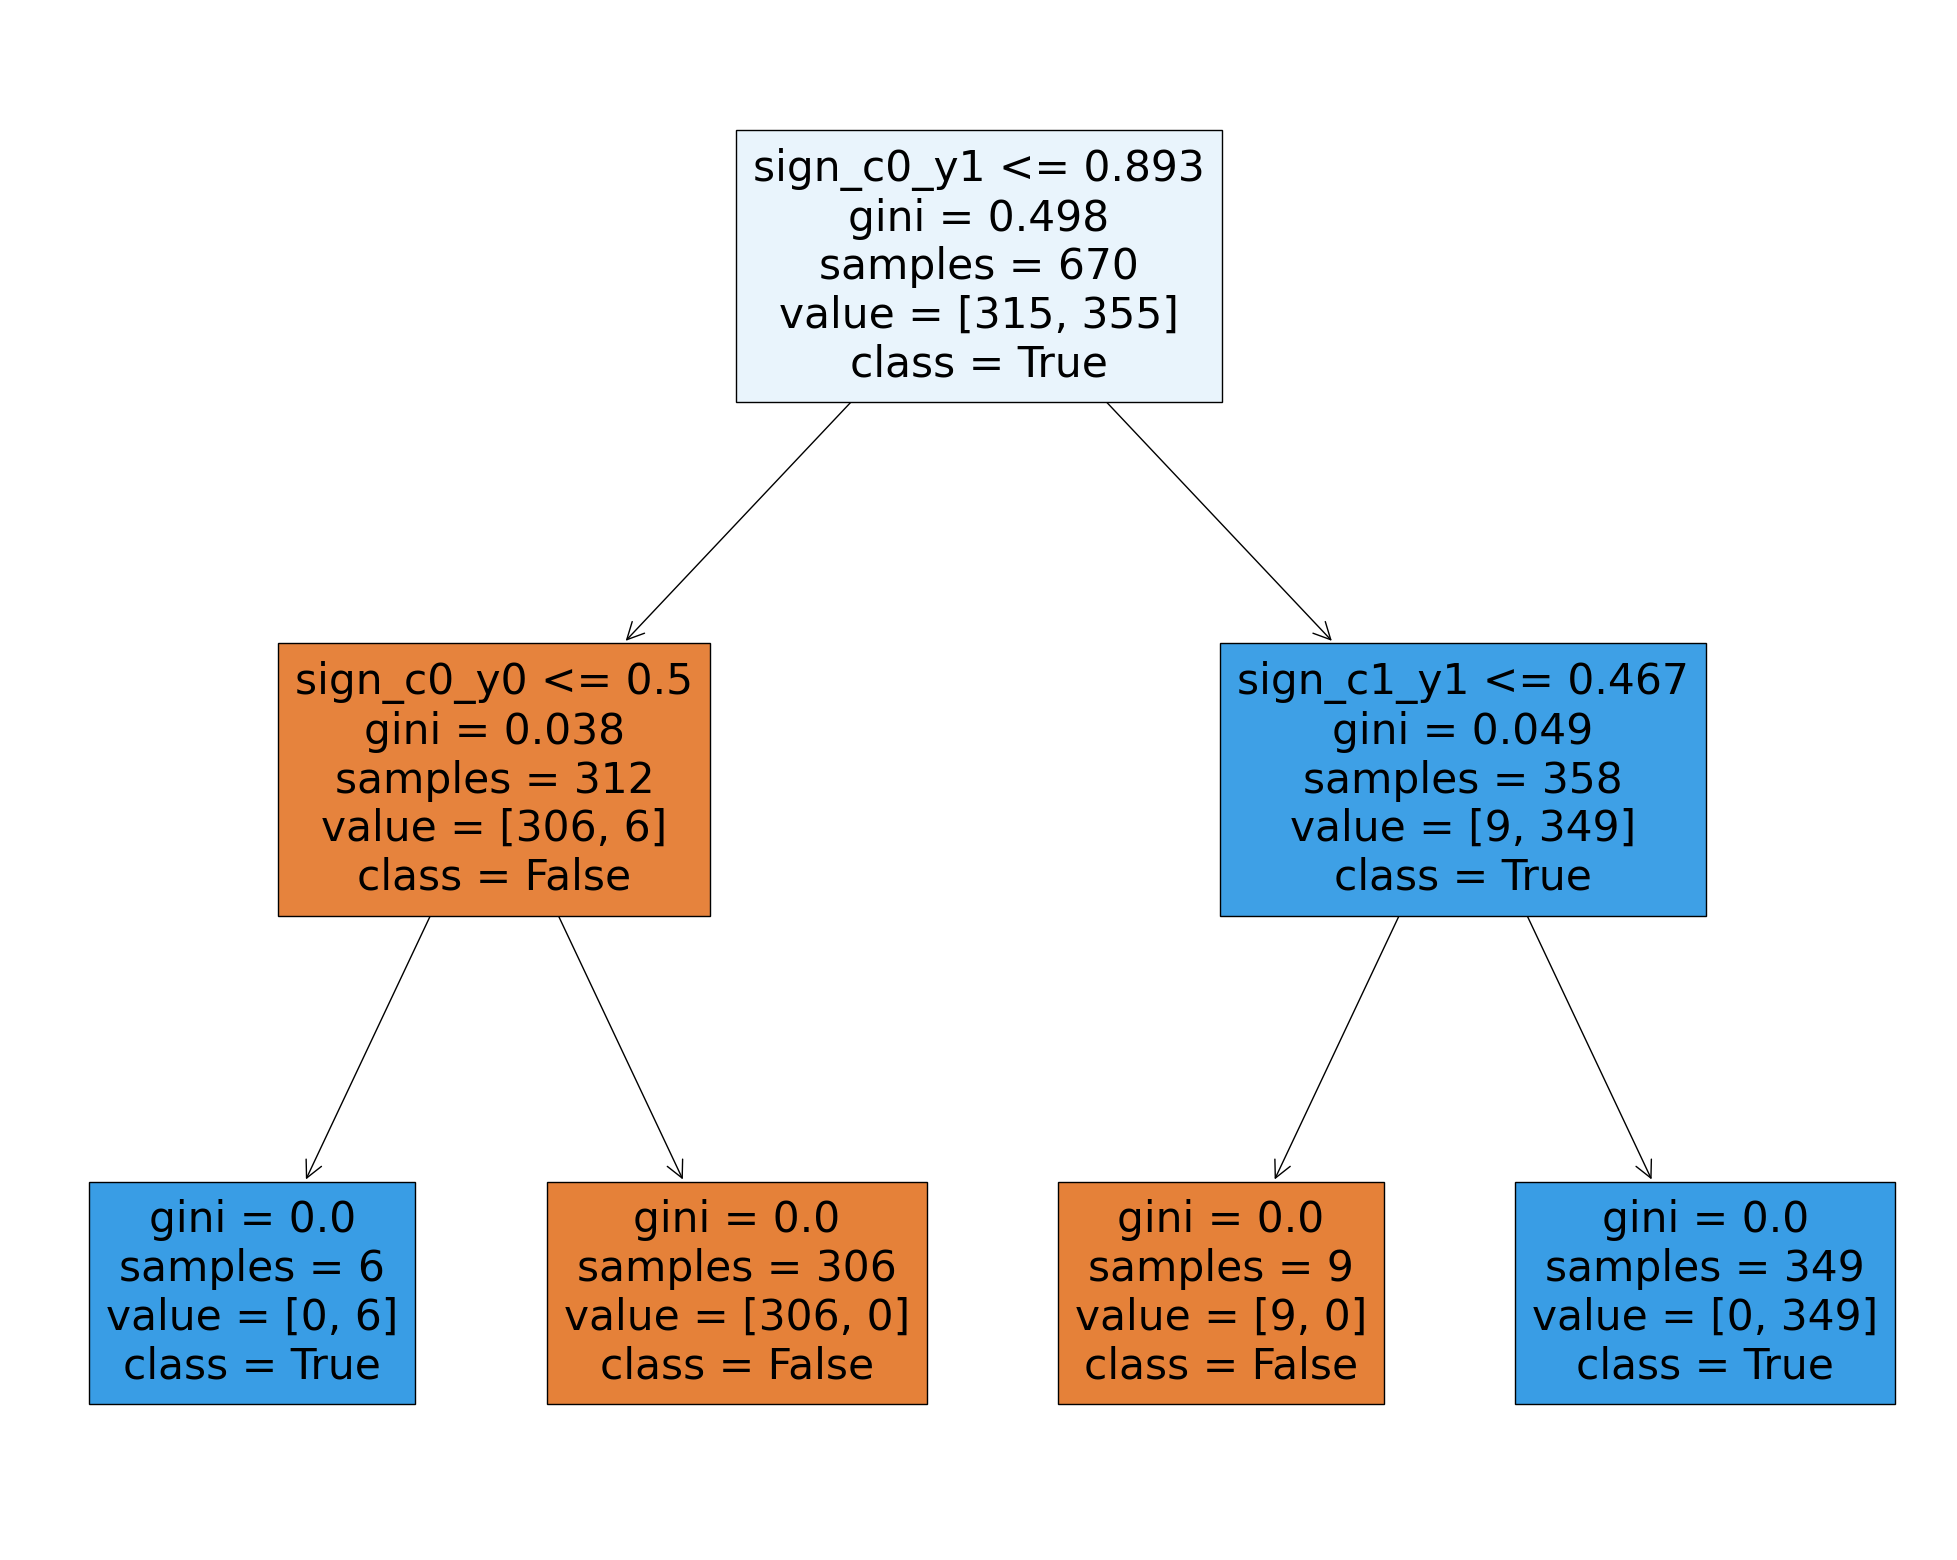

In [33]:
# Let's plot the result
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt, feature_names=df.columns, class_names=['False', 'True'], filled=True)
plt.show()

In [17]:
# Evaluation of accuracy score on TEST SET

c_emb_test, c_pred_test = concept_encoder.forward(x_test)
y_pred_dt_test, sign_attn_dt_test, filter_attn_dt_test = task_predictor.forward(c_emb_test, c_pred_test, return_attn=True)

values_test = c_pred_test.unsqueeze(-1).repeat(1, 1, len(y_pred_dt_test[1]))
sign_terms_dt_test = logic.iff_pair(sign_attn_dt_test, values_test)

In [18]:
sign_concept_0_test = np.vstack([sign.detach().numpy() for sign in sign_terms_dt_test[:,0,:]])
sign_concept_1_test = np.vstack([sign.detach().numpy() for sign in sign_terms_dt_test[:,1,:]])
filter_concept_0_test = np.vstack([f.detach().numpy() for f in filter_attn_dt_test[:,0,:]])
filter_concept_1_test = np.vstack([f.detach().numpy() for f in filter_attn_dt_test[:,1,:]])

final_features_test = np.hstack((sign_concept_0_test, filter_concept_0_test, sign_concept_1_test, filter_concept_1_test))
df_test = pd.DataFrame(final_features_test, columns=names)

In [19]:
y_predicted = dt.predict(df_test)
y_test_dt = ['False' if pred[0] else 'True' for pred in y_test]
accuracy_score(y_test_dt, y_predicted)

0.996969696969697

Now I train 2 different DTs, one for each class (y0, y1)

In [20]:
# Crea un DataFrame con solo le colonne y0
df_y0 = df.filter(like='y0')

# Crea un DataFrame con solo le colonne y1
df_y1 = df.filter(like='y1')

In [21]:
y_dt0 = [True if pred[0] else False for pred in y_pred_dt>0.5] # If pred[0] is True -> it belongs to class y0
y_dt1 = [True if pred[1] else False for pred in y_pred_dt>0.5] # If pred[1] is True -> it belongs to class y1

clf0 = DecisionTreeClassifier(random_state=SEED)
clf0.fit(df_y0, y_dt0)

clf1 = DecisionTreeClassifier(random_state=SEED)
clf1.fit(df_y1, y_dt1)

DecisionTreeClassifier(random_state=42)

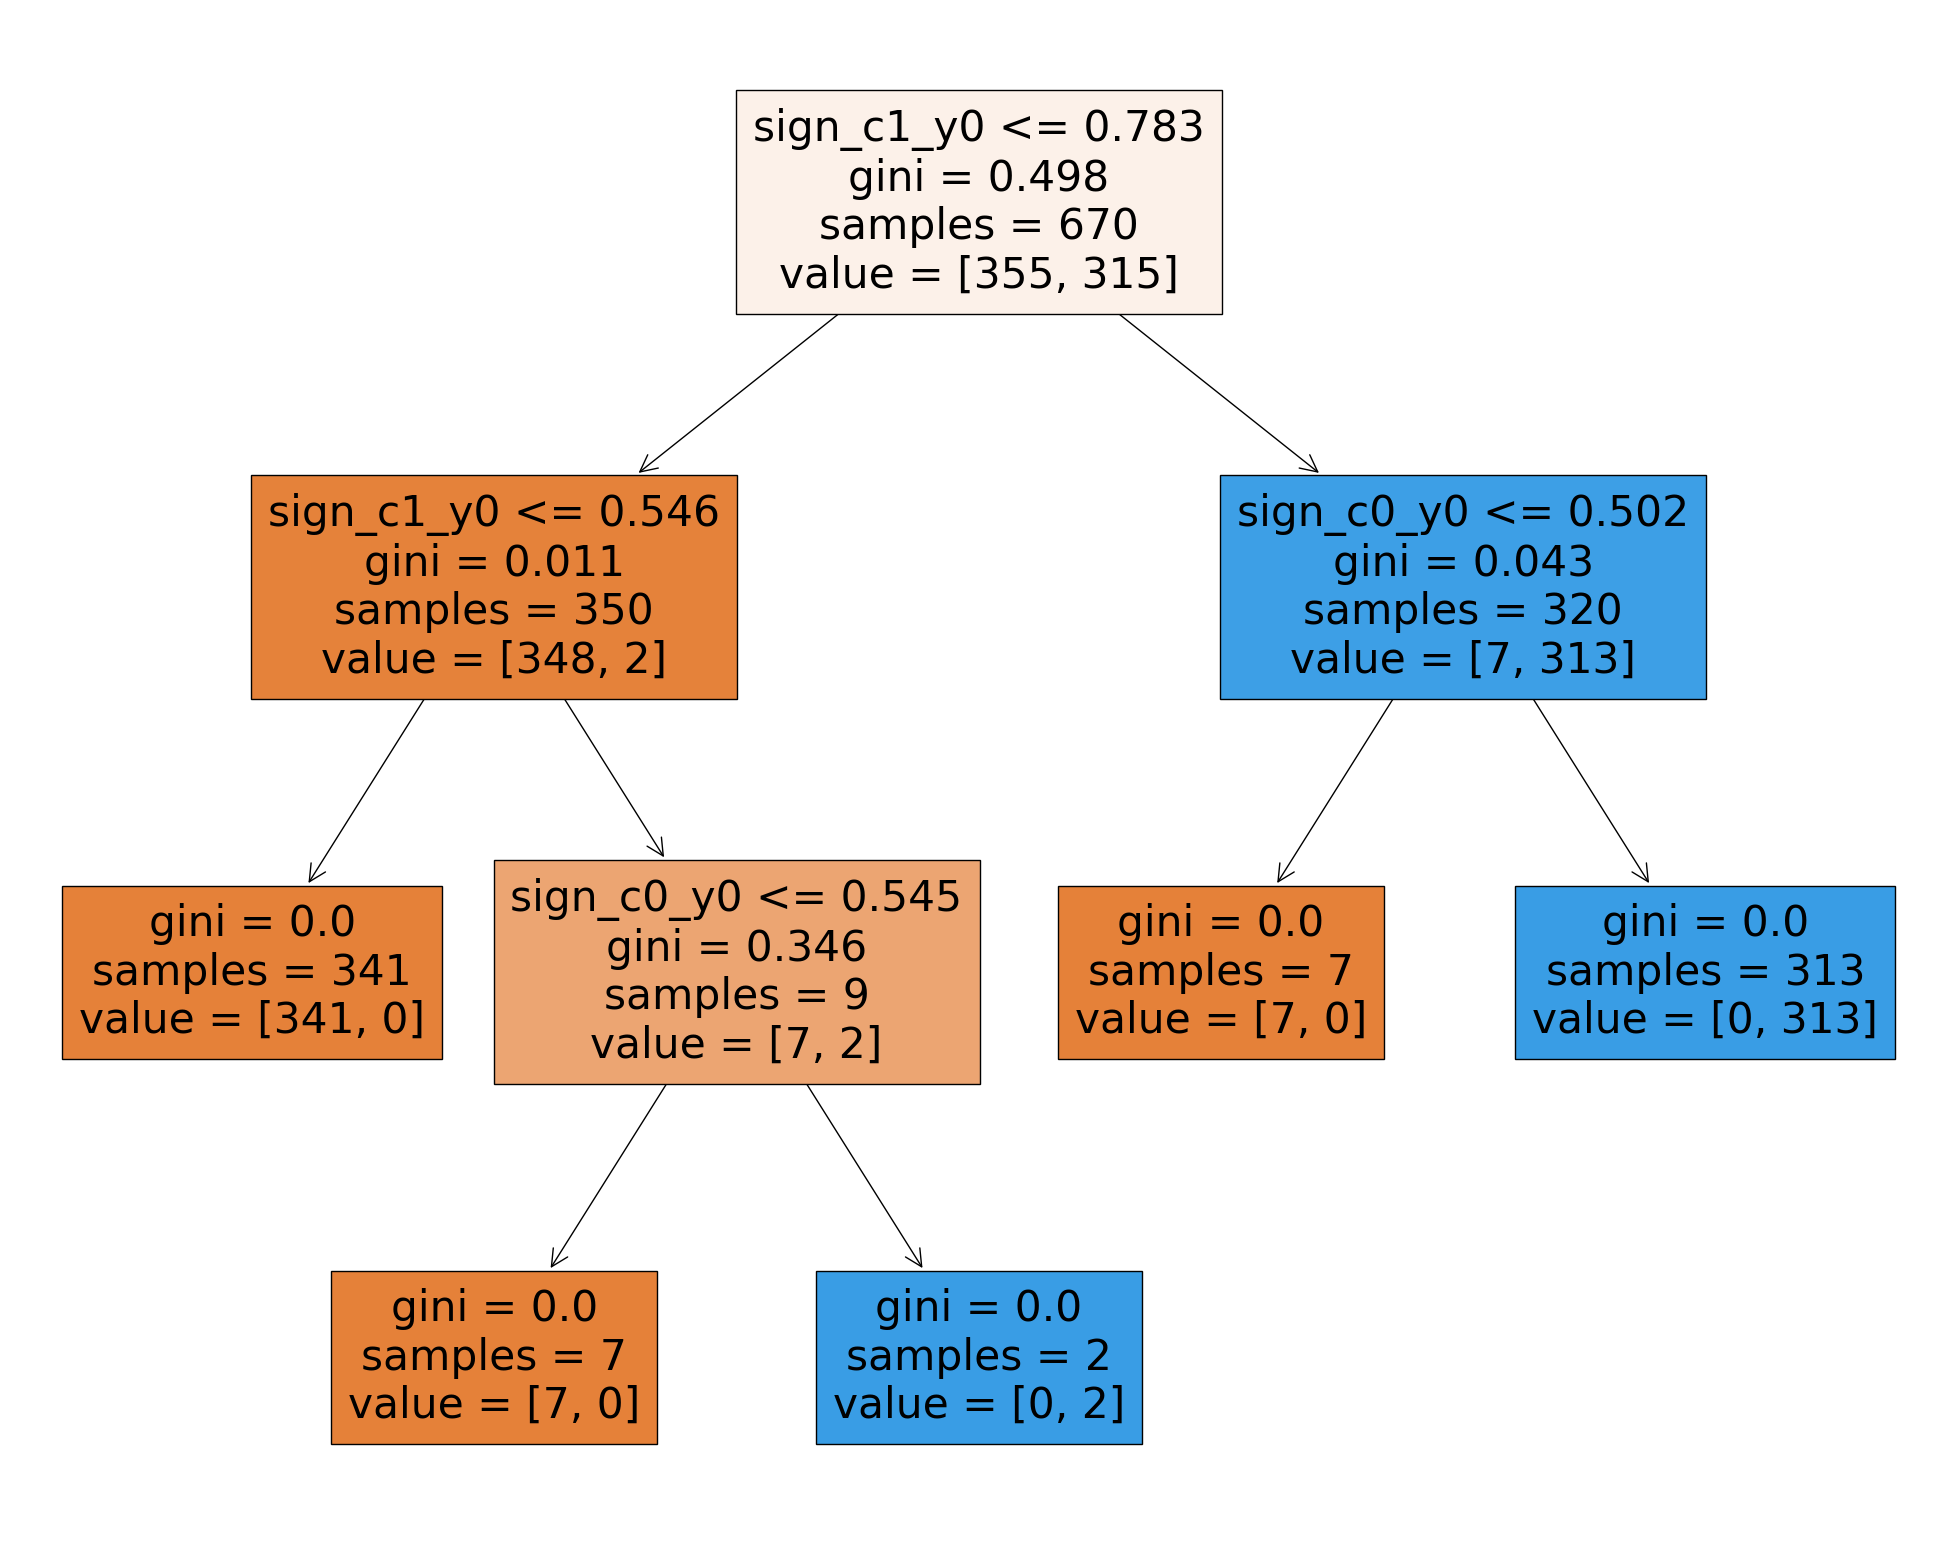

In [22]:
# Plot for Y0

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf0, feature_names=df_y0.columns, filled=True)
plt.show()

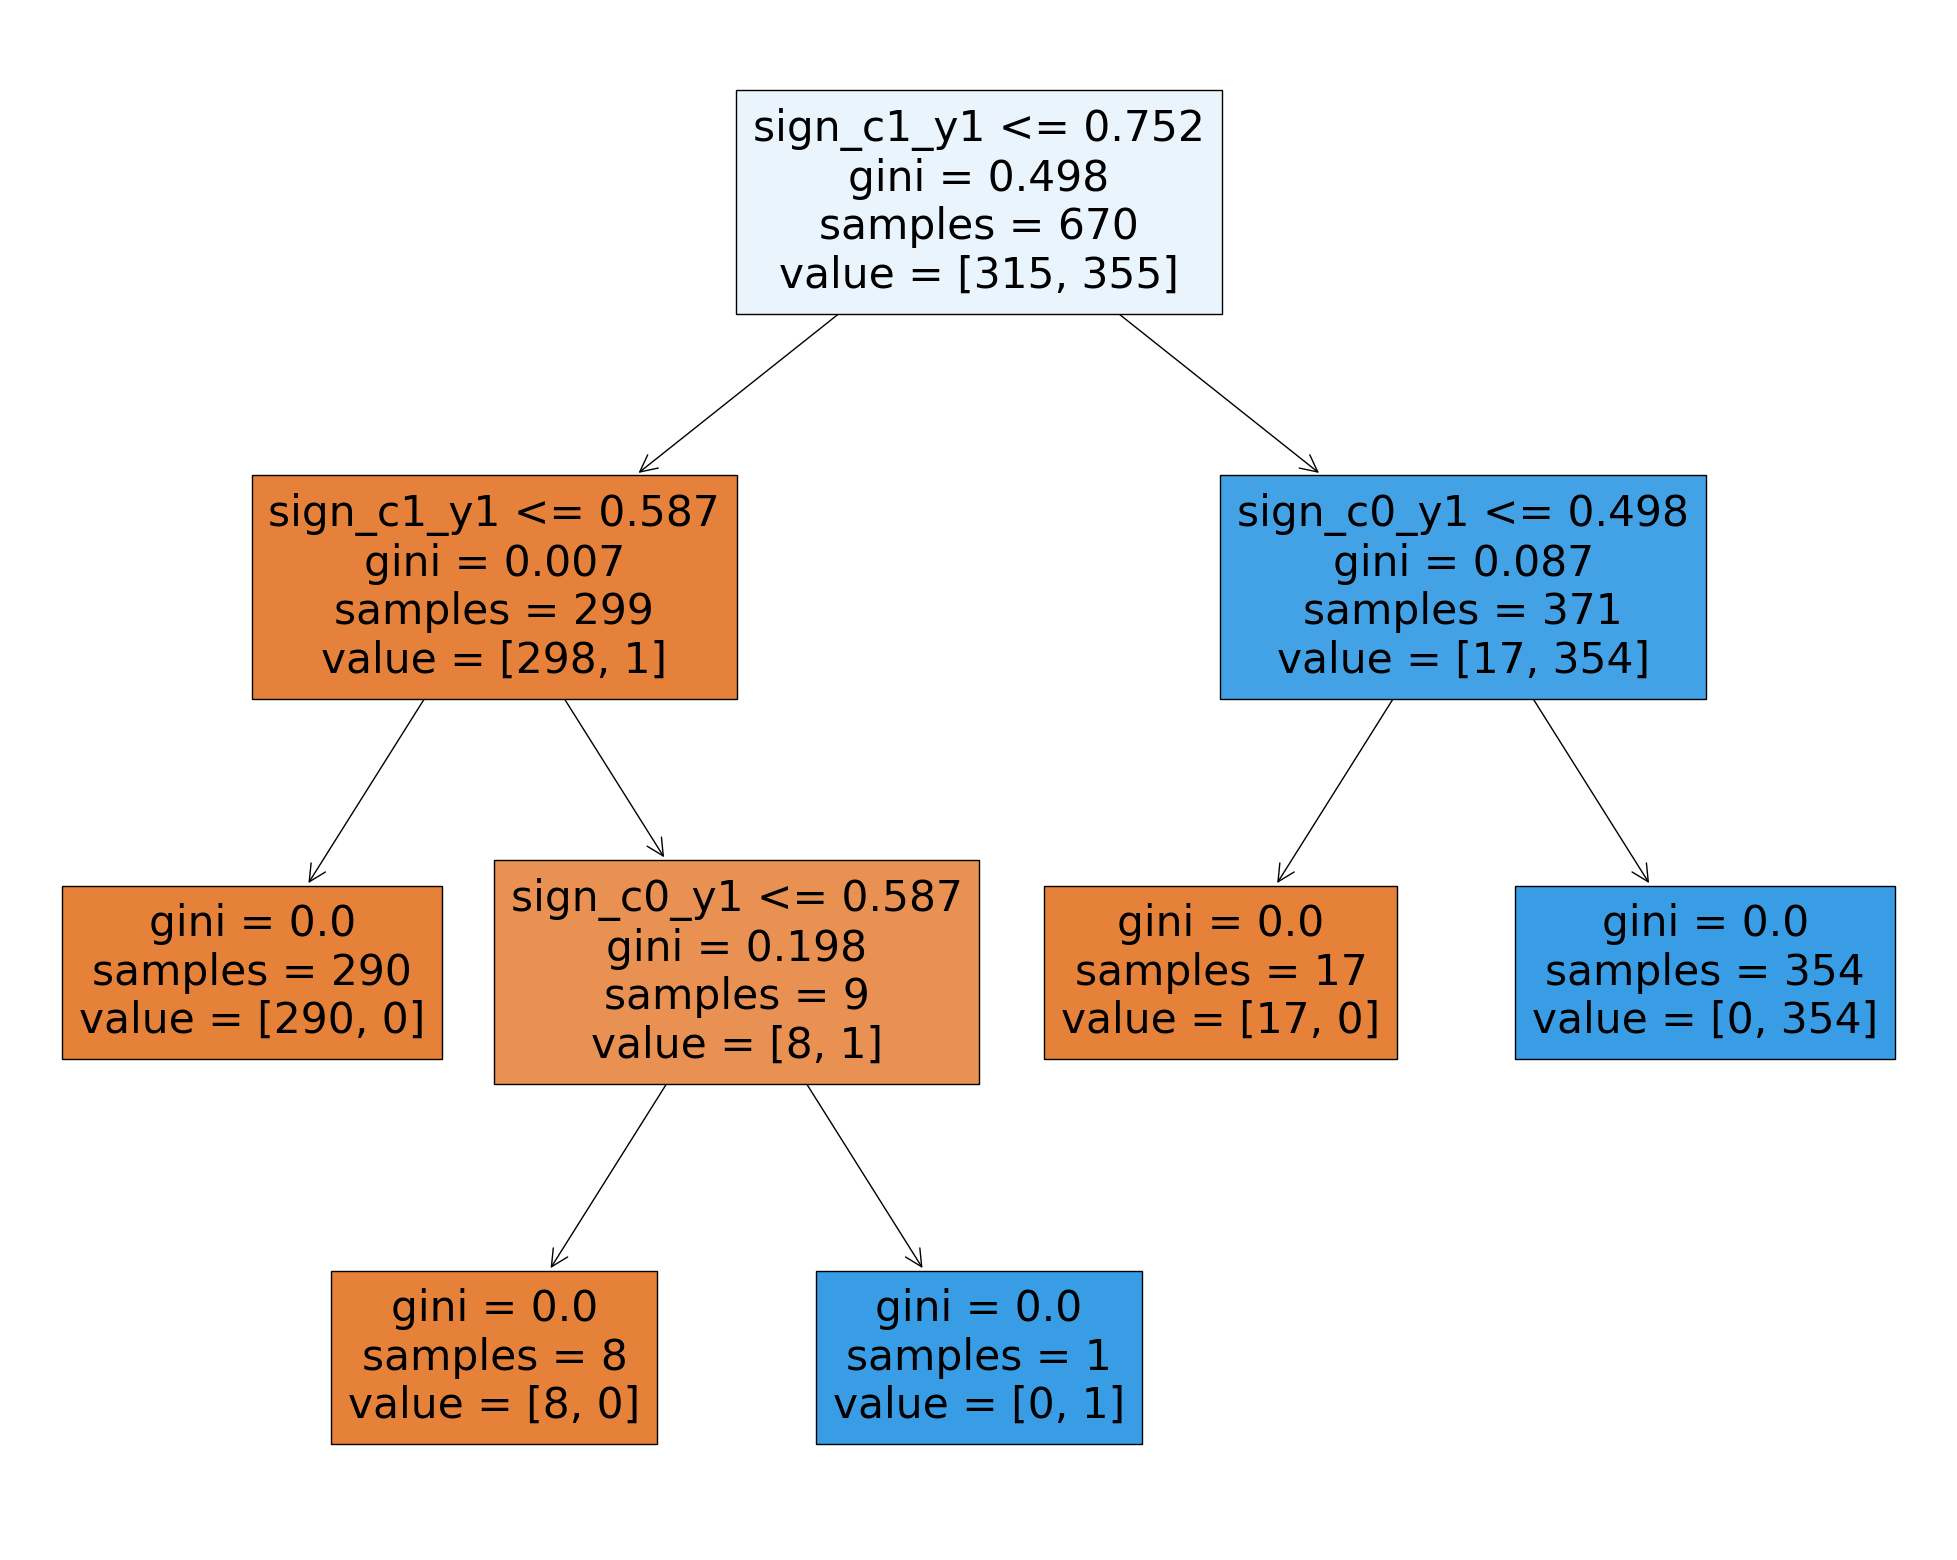

In [23]:
# Plot for Y1

fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf1, feature_names=df_y1.columns, filled=True)
plt.show()